<a href="https://colab.research.google.com/github/atulgupta01/EVA_Group_Assignment/blob/master/P2S10/P2S10_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2 as cv
from google.colab.patches import cv2_imshow
from PIL import Image
from scipy import ndimage
import copy
from PIL import Image as PILImage
import numpy as np
import math

import os
import time
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import deque

In [0]:
car_file = 'car.png'
city_file = 'citymap.png'
city_map_file = "MASK1.png"

In [0]:

class car(object):

  # x and y are center points of the car

    def __init__(self,x,y,angle,):
        self.x = x
        self.y = y
        (self.length, self.width) = (int(20), int(10))
        self.angle = angle

    def move(self,velocity_x,velocity_y,rotation):
        self.x = self.x + velocity_x
        self.y = self.y + velocity_y
        self.angle = self.angle + rotation

        if self.angle > 360:
            self.angle = self.angle % 360
        elif self.angle < -360:
            self.angle = self.angle % -360


In [0]:

class city(object):

    def __init__(self, city_file):
        self.city_file = city_file
        self.city_img = cv.imread(self.city_file)
        (self.width, self.length, _) = self.city_img.shape

    def draw_car(self,x,y,width,height,angle,img):

        _angle = (180 - angle) * math.pi / 180.0
        b = math.cos(_angle) * 0.5
        a = math.sin(_angle) * 0.5
        pt0 = (int(x - a * height - b * width), int(y + b * height - a* width))
        pt1 = (int(x + a * height - b * width), int(y - b * height - a* width))
        pt2 = (int(2 * x - pt0[0]), int(2 * y - pt0[1]))
        pt3 = (int(2 * x - pt1[0]), int(2 * y - pt1[1]))
        pt4 = (int((pt0[0] + pt1[0]) / 2), int((pt0[1] + pt1[1]) / 2))
        pt5 = (int((pt0[0] + pt3[0]) / 2), int((pt0[1] + pt3[1]) / 2))
        pt6 = (int((pt1[0] + pt2[0]) / 2), int((pt1[1] + pt2[1]) / 2))

        line_color = (200, 200, 200)
        line_thickness = 5

    # print(pt0, pt1, pt2, pt3, pt4)

        cv.line(img, pt2, pt3, line_color, line_thickness)
        cv.line(img, pt3, pt5, line_color, line_thickness)
        cv.line(img, pt6, pt2, line_color, line_thickness)
        cv.line(img, pt5, pt4, line_color, line_thickness)
        cv.line(img, pt6, pt4, line_color, line_thickness)

    def get_current_loc_map(self,x,y,size,angle=0,state=False):

        newcity_img = copy.deepcopy(self.city_img)

        if x - size / 2 < 0 or y - size / 2 < 0 or x + size / 2 \
            > self.length - 1 or y + size / 2 > self.width - 1:
            return np.ones((size, size, 3))
        else:
            y = self.width - y

        if state == True:
            img_crop = self.draw_car(x,y,20,10,angle,newcity_img)

        img_crop = newcity_img[int(y - size / 2):int(y) + int(size / 2), \
                               int(x - size / 2):int(x) + int(size / 2)]
        img_state = np.average(img_crop, axis=2) / 255
        img_state = img_state.reshape(size, size, -1)
        return (img_crop, img_state)


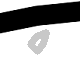

In [32]:
citymap = city(city_map_file)
img_crop, _ = citymap.get_current_loc_map(1240, 600, 80, angle=45,state = True)
cv2_imshow(img_crop)
#img_crop, _ = citymap.get_current_loc_map(1240, 600, 80, angle=0,state = False)
#cv2_imshow(img_crop)

In [0]:
class env(object):

    def __init__(self,car,city,city_map,car_img,):
        self.car = car
        self.city = city
        self.city_map = city_map
        self.car_img = car_img
        self.car_img = cv.resize(self.car_img, dsize=(self.car.length,self.car.width))
        self.size = 80

        self.goal_x = 575
        self.goal_y = 530
        self.swap = 0

    # car_x and car_y are center points of the car

    def show_image(self):
        newcity = copy.deepcopy(self.city)
        car_rotated = ndimage.rotate(self.car_img, self.car.angle)
        (car_wid, car_len, _) = car_rotated.shape
        pos_x = self.car.x - car_len // 2
        pos_y = newcity.width - (self.car.y - car_wid // 2)

        if pos_x < 0:
            pos_x = 0
        elif pos_x > newcity.length:
            pos_x = newcity.length - car_len

        if pos_y > newcity.width:
            pos_y = newcity.width - car_wid
        elif pos_y < 0:
            pos_y = 0

        car_rotated = cv.addWeighted(newcity.city_img[pos_y:pos_y \
                + car_wid, pos_x:pos_x + car_len], 0.5, car_rotated, 1,0)
        newcity.city_img[pos_y:pos_y + car_wid, pos_x:pos_x + car_len] = car_rotated
        return newcity

    def step(self, action):
        self.reward = 0
        self.velocity_x = 0.5
        self.velocity_y = 0
        done = False

        angle = math.radians(action)
        self.velocity_x = self.velocity_x * math.cos(angle) \
            - self.velocity_y * math.sin(angle)
        self.velocity_y = self.velocity_y * math.cos(angle) \
            + self.velocity_x * math.sin(angle)
        self.car.move(self.velocity_x, self.velocity_y, action)
        xx = self.goal_x - self.car.x
        yy = self.goal_y - self.car.y

        distance = np.sqrt((self.car.x - self.goal_x) ** 2 + (self.car.y - self.goal_y) ** 2)
    
        car_loc, _ = self.city_map.get_current_loc_map(self.car.x,self.car.y, self.size)
        sand_quality = np.sum(car_loc)
        sand_quality = sand_quality / (self.size * self.size * 3 * 255)
    
        # moving on the sand
        # check coordinates carefully image cordinate y is inverse of car coordinate y
    
        sand_check = np.sum(self.city_map.city_img[int(self.city.width \
                            - self.car.y), int(self.car.x)]) / (255 * 3)
    
        if sand_check > 0:  # **** Check whether coords are correct
            self.reward = self.reward - 5.0
        else:
    
               # moving on the road
    
            self.reward = self.reward - 1.5
    
        if self.car.x - int(self.car.length / 2) < 5 or self.car.y \
            - int(self.car.width / 2) < 5 or self.car.x \
            - int(self.car.length / 2) > self.city_map.length - 5 \
            or self.car.y - int(self.car.width / 2) > self.city_map.width - 5:
            self.boundary_hit_count = self.boundary_hit_count + 1
            self.reward = self.reward - 5.0
    
        if distance < self.last_distance:
            self.reward = self.reward + 5
        else:
            self.reward = self.reward + 2
    
        if distance < 25:
            self.reward = self.reward + 100
    
            self.goal_hit_count += 1
    
            if self.swap == 1:
                print ('Hit the Goal 2: (' + str(self.goal_x) + ', ' + str(self.goal_y) + ')')
                #traversal_log.write('Train episode: '
                #                    + str(train_episode_num)
                #                   + ' Eval episode: '
                #                    + str(eval_episode_num)
                #                    + ' : Hit the Goal 2: (' + str(goal_x)
                #                    + ', ' + str(goal_y) + ')\n')
                
                self.goal_x = 575
                self.goal_y = 530
                self.swap = 0
                done = True
            else:
                print ('Hit the Goal 1: (' + str(self.goal_x) + ', ' + str(self.goal_y) + ')')
                #traversal_log.write('Train episode: '
                #                    + str(train_episode_num)
                #                    + ' Eval episode: '
                #                    + str(eval_episode_num)
                #                    + ' : Hit the Goal 1: (' + str(goal_x)
                #                    + ', ' + str(goal_y) + ')\n')
                
                self.goal_x = 610
                self.goal_y = 45
                self.swap = 1
                done = True
    
        self.last_distance = distance
        self.current_step += 1
    
        _, img_state = self.city.get_current_loc_map(self.car.x, self.car.y,\
                self.size, self.car.angle, state=True)
        self.last_action = action
        self.last_reward = self.reward
    
        return img_state, self.reward, done

    def reset(self):

        longueur = self.city.length
        largeur = self.city.width

        self.on_road_count = 0
        self.off_road_count = 0
        self.boundary_hit_count = 0
        self.goal_hit_count = 0
        self.episode_total_reward = 0.0
        self.reward = 0
        self.last_reward = 0
        self.last_action = 0
        self.goal_x = 575
        self.goal_y = 530
        self.swap = 0
        self.last_distance = 0
        self.current_step = 0

        self.car.angle = 0.0
        self.car.x = np.random.randint(100, longueur - 100)
        self.car.y = np.random.randint(100, largeur - 100)
        
        _, img_state = self.city.get_current_loc_map(self.car.x, self.car.y,\
                self.size, self.car.angle, state=True)
        return [img_state, self.car.angle]



In [0]:
class Actor(nn.Module):

  def __init__(self, state_dim, action_dim, max_action):
    super(Actor, self).__init__()
    # assuming input state image size to be 40x40
    self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
              nn.BatchNorm2d(8),nn.ReLU(),nn.Dropout(0.1)) # output_size = 38
          
    self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
              nn.BatchNorm2d(16),nn.ReLU(),nn.Dropout(0.1)) # output_size = 36
    
    self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
              nn.BatchNorm2d(16),nn.ReLU(),nn.Dropout(0.1)) # putput_size = 34

    self.pool1 = nn.MaxPool2d(2, 2) # output_size = 17
    self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
              nn.BatchNorm2d(8),nn.ReLU(),nn.Dropout(0.1)) # output_size = 17
                
    self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
              nn.BatchNorm2d(16),nn.ReLU(),nn.Dropout(0.1)) # output_size = 15
          
    self.convblock6 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
              nn.BatchNorm2d(32),nn.ReLU(),nn.Dropout(0.1)) # output_size = 13

    self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
              nn.BatchNorm2d(32),nn.ReLU(),nn.Dropout(0.1)) # output_size = 11
          
    self.GAP = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)))

    # we will have 32 values coming from GAP layer and (state_dim-1) other state values 
    self.fc1 = nn.Linear(state_dim - 1 + 32, 400)
    self.fc2 = nn.Linear(400, 300)
    self.fc3 = nn.Linear(300, action_dim)

    self.max_action = max_action

  def forward(self, stateImg,stateValues):
    x = stateImg  # first state element is cropped image
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)
    x = self.pool1(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = self.GAP(x)
    x = x.view(-1, 32)
    # concatenate with rest of the state elements
    x = torch.cat([x, stateValues], 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.max_action * torch.tanh(self.fc3(x))
    return x
  

In [0]:
def select_action(model,state):
  stateImg=np.expand_dims(state[0],1)
  stateValues = np.array(state[1:], dtype=np.float)
  stateValues = np.expand_dims(stateValues,0)
  stateValues = torch.Tensor(stateValues.reshape(1, -1)).to(device)
  stateImg = torch.Tensor(stateImg).to(device)
  return(actorNet(stateImg,stateValues).cpu().data.numpy().flatten())


In [0]:
#test actor individually
# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actorNet = Actor(state_dim=2, action_dim=1, max_action=5.0).to(device)


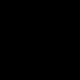

(80, 80, 1)


In [113]:
car_img = cv.imread(car_file)
car1 = car(200,200,30)
city1 = city(city_file)
citymap = city(city_map_file)

carEnv = env(car1, city1, citymap, car_img)
carEnv.reset()
stateImg,reward,done = carEnv.step(action = 0.5)
cv2_imshow(stateImg)
print(stateImg.shape)



In [114]:
stateImg2 = np.transpose(stateImg,(2,0,1))
print(stateImg2.shape)

state = np.array([stateImg2,50.0])
print(state.shape)

print(select_action(actorNet,state))

(1, 80, 80)
(2,)
[3.2447312]
